In [1]:
''' 
No longer possible to compute matrix A given 28 dimension inputs
'''
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Sampler, random_split, Dataset
from torchvision import datasets, transforms
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from collections import defaultdict
from line_profiler import profile
from sklearn.model_selection import train_test_split

import src.data_processing.ImageCalculations as imgcalc
import src.visualization.BFmethod as graphing
import src.visualization.Metrics as metrics
import src.visualization.ImagePlots as imgplt
import src.data_processing.ImageProducts as ImageProducts
import src.helpers.ModelUtilities as models

from functools import partial
from learnable_polyphase_sampling.learn_poly_sampling.layers import get_logits_model, PolyphaseInvariantDown2D, LPS
from learnable_polyphase_sampling.learn_poly_sampling.layers.polydown import set_pool

/home/jovyan/miniconda3/envs/test/lib/python3.12/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


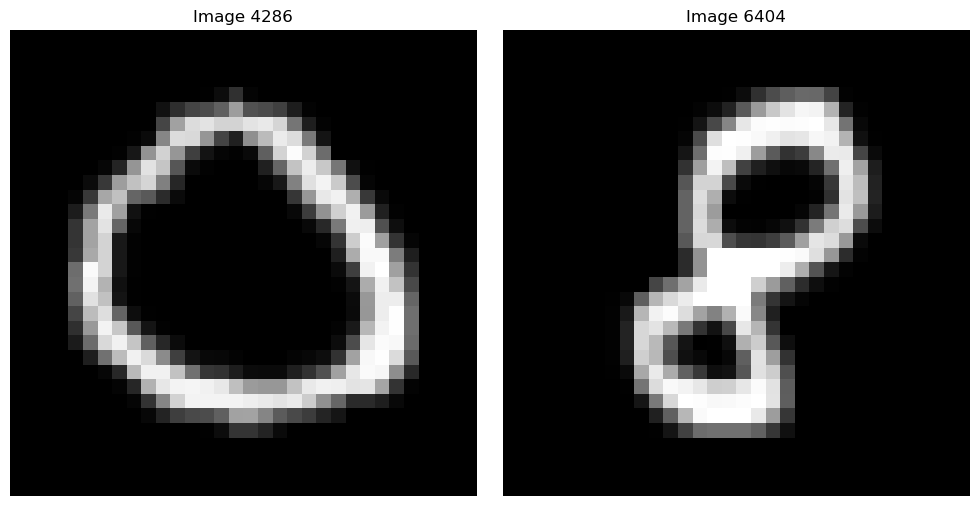

In [2]:
# ----------------------------------Test for unique image----------------------------------
k=5
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
testset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)
full_dataset = testset
# ----------------------------------Preparing the Dataset----------------------------------
index1 = np.random.randint(len(full_dataset))
index2 = np.random.randint(len(full_dataset))
    
input_dataset = []
for i in range(len(full_dataset)):
    image,label = full_dataset[i]
    img = image.unsqueeze(0).cuda().double()  #1x1xHxW
    input_dataset.append(img)

stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).cuda().float() for data in input_dataset]

NCC_dataset = []
for i in range(len(full_dataset)):
    image,label = full_dataset[i]
    image_array = image.numpy()
    NCC_dataset.append(image_array.squeeze()) 
    
input1 = NCC_dataset[index1]
input2 = NCC_dataset[index2]

imgplt.plot_original_images(input1, input2, index1, index2)

In [3]:
# -----------------------------Evaluating Results-----------------------------
model = models.CNN().cuda()
model.load_state_dict(torch.load('model/best_model_batch_greyscale_mnistComplexCNN.pt', weights_only=True))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
#----------------------Metric 1 - Loss Calculation-----------------

NCC_scaled_value = imgcalc.get_NCC_score(input1, input2)
print("\nLoss calculation")
print("\nScaled NCC: ",NCC_scaled_value)

embedded_vector_image1 = model(input_dataset[index1])
embedded_vector_image2 = model(input_dataset[index2])

dot_product_value = imgcalc.get_dp_score(embedded_vector_image1, embedded_vector_image2)

print("Dot product value of model: ", dot_product_value.item())

loss_value = imgcalc.get_loss_value(dot_product_value, NCC_scaled_value) 
print("Loss: ", loss_value)


Loss calculation

Scaled NCC:  0.455288290977478
Dot product value of model:  0.39604395627975464
Loss:  0.05924433469772339



Model Method -- KNN-IOU score for k = 5


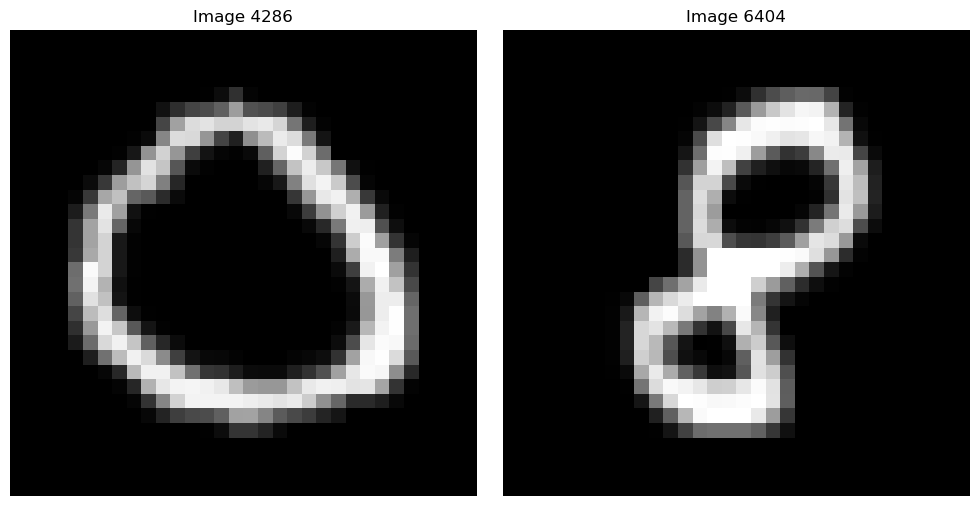

Estimating K-Score for Image 4286: K-Score = 0.2

Top 10 values of Vector b
Rank 1: Value = 1.0, Index = 4286
Rank 2: Value = 0.879822850227356, Index = 1271
Rank 3: Value = 0.8746843338012695, Index = 246
Rank 4: Value = 0.8689174652099609, Index = 126
Rank 5: Value = 0.865520715713501, Index = 2932
Rank 6: Value = 0.8530846834182739, Index = 721
Rank 7: Value = 0.8438881635665894, Index = 4992
Rank 8: Value = 0.8425412178039551, Index = 1009
Rank 9: Value = 0.8374392986297607, Index = 3849
Rank 10: Value = 0.8364696502685547, Index = 3735

Top 10 values of Vector c
Rank 1: Value = 1.0, Index = 4286
Rank 2: Value = 0.9312546253204346, Index = 126
Rank 3: Value = 0.9213868379592896, Index = 2568
Rank 4: Value = 0.9182170629501343, Index = 4327
Rank 5: Value = 0.88886559009552, Index = 1468
Rank 6: Value = 0.885897159576416, Index = 2485
Rank 7: Value = 0.8775708675384521, Index = 3735
Rank 8: Value = 0.8748874664306641, Index = 1807
Rank 9: Value = 0.8561316728591919, Index = 2932
Rank

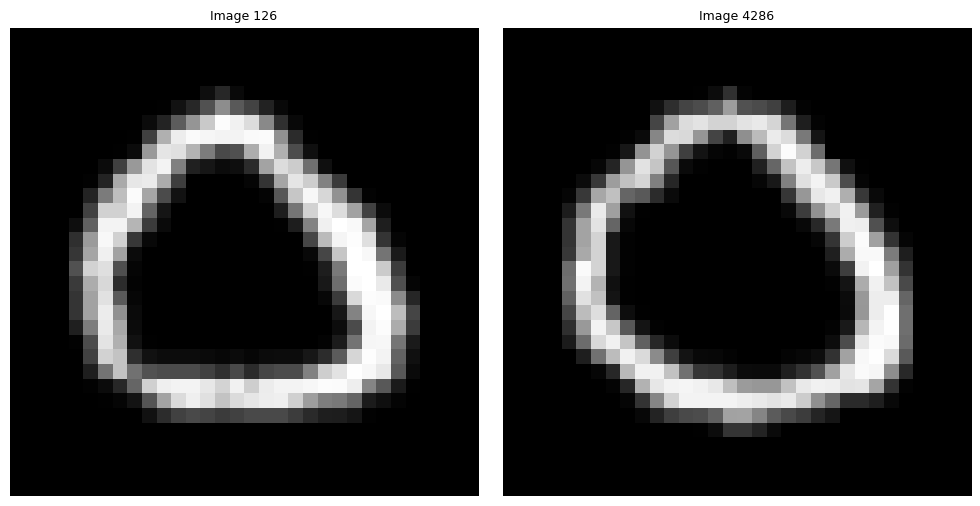


Plotting images in the union set:


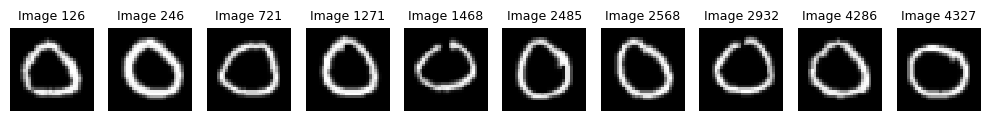


For translationally unique plots: 
Image 126 has no translationally similar images.
Image 246 has no translationally similar images.
Image 721 has no translationally similar images.
Image 1271 has no translationally similar images.
Image 1468 has no translationally similar images.
Image 2485 has no translationally similar images.
Image 2568 has no translationally similar images.
Image 2932 has no translationally similar images.
Image 4286 has no translationally similar images.
Image 4327 has no translationally similar images.

Plotting images in the intersection set:


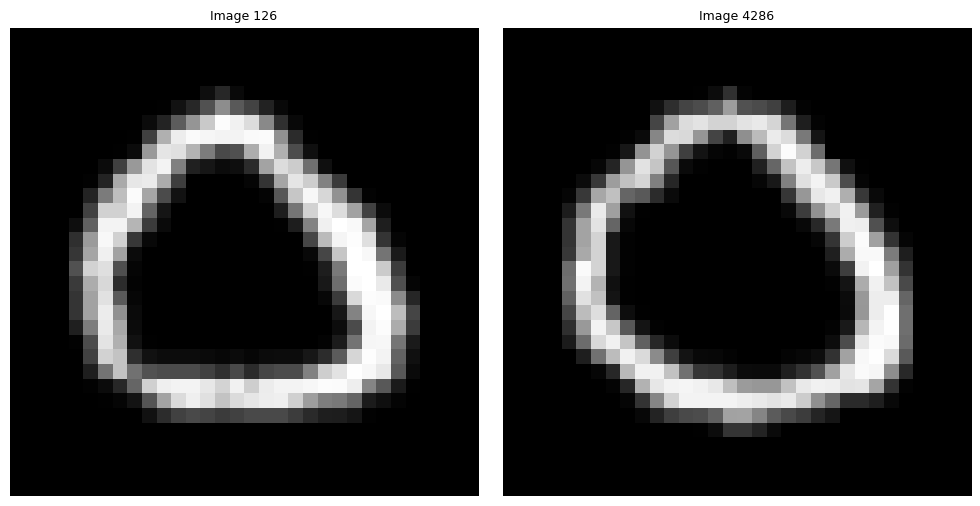


Plotting images in the union set:


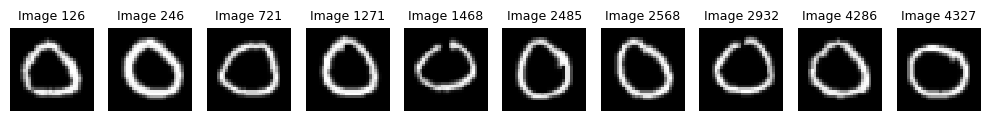

Estimating K-Score for Image 6404: K-Score = 0.7142857142857143

Top 7 values of Vector b
Rank 1: Value = 1.0, Index = 6404
Rank 2: Value = 0.9202749729156494, Index = 6336
Rank 3: Value = 0.9152042865753174, Index = 6327
Rank 4: Value = 0.8946400880813599, Index = 6317
Rank 5: Value = 0.8847687244415283, Index = 983
Rank 6: Value = 0.8843485116958618, Index = 1560
Rank 7: Value = 0.8783845901489258, Index = 6776

Top 7 values of Vector c
Rank 1: Value = 1.0, Index = 6404
Rank 2: Value = 0.9404907822608948, Index = 6327
Rank 3: Value = 0.9243776202201843, Index = 6336
Rank 4: Value = 0.9207580089569092, Index = 983
Rank 5: Value = 0.9113223552703857, Index = 8209
Rank 6: Value = 0.9101027250289917, Index = 1560
Rank 7: Value = 0.9069633483886719, Index = 6343

Comparison between vector c and vector b
 Index  Vector b Value (NCC value)  Vector c Value (Dot product value)
  6404                    1.000000                            1.000000
   983                    0.884769            

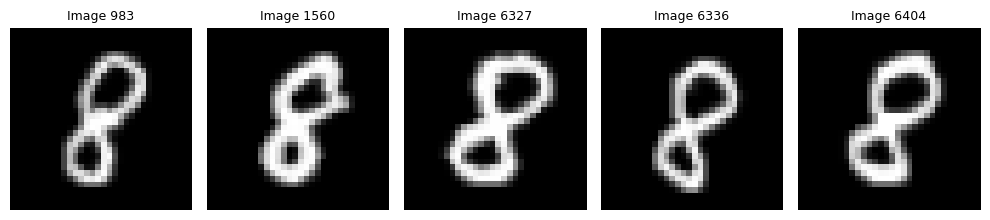


Plotting images in the union set:


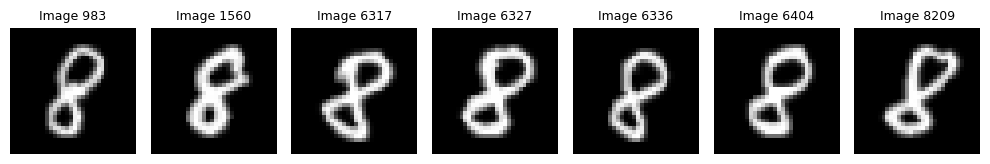


For translationally unique plots: 
Image 983 has no translationally similar images.
Image 1560 has no translationally similar images.
Image 6317 has no translationally similar images.
Image 6327 has no translationally similar images.
Image 6336 has no translationally similar images.
Image 6404 has no translationally similar images.
Image 8209 has no translationally similar images.

Plotting images in the intersection set:


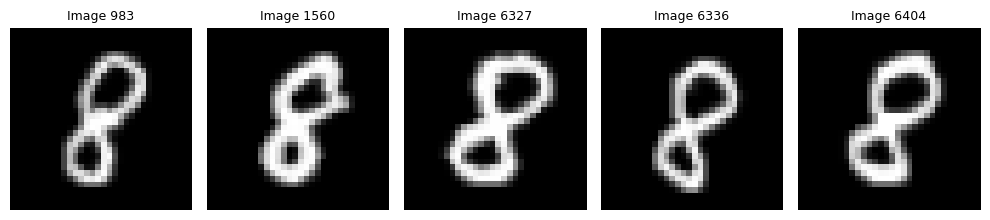


Plotting images in the union set:


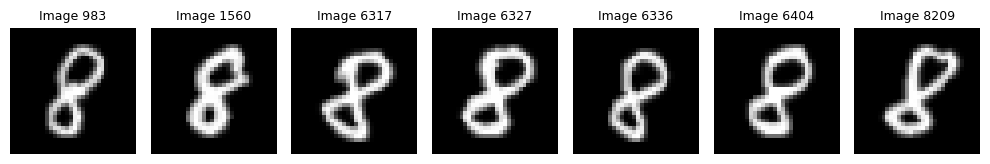

In [4]:
#----------------------Metric 2 - KNNIoU-----------------
print(f"\nModel Method -- KNN-IOU score for k = {k}")

imgplt.plot_original_images(NCC_dataset[index1], NCC_dataset[index2], index1, index2)
vectorb_model1 = imgcalc.get_vectorb_model(index1, model, NCC_dataset)
vectorc_model1 = imgcalc.get_vectorc_model(index1, model, input_dataset)
imgplt.display_and_plot_results(vectorb_model1, vectorc_model1, "Model", index1, k, NCC_dataset)
   
vectorb_model2 = imgcalc.get_vectorb_model(index2, model, NCC_dataset)        
vectorc_model2 = imgcalc.get_vectorc_model(index2, model, input_dataset)
imgplt.display_and_plot_results(vectorb_model2, vectorc_model2, "Model", index2, k, NCC_dataset)

10

Generating K-Score for index 8772 of label 0
K-Score for index 8772 is 0.7142857142857143
Average loss for index 8772 is 0.07929571379721165

Generating K-Score for index 3452 of label 1
K-Score for index 3452 is 0.2
Average loss for index 3452 is 0.043961358392238616

Generating K-Score for index 7420 of label 2
K-Score for index 7420 is 0.5
Average loss for index 7420 is 0.04104128601551056

Generating K-Score for index 1588 of label 3
K-Score for index 1588 is 0.2
Average loss for index 1588 is 0.035454149800539014

Generating K-Score for index 7194 of label 4
K-Score for index 7194 is 0.3333333333333333
Average loss for index 7194 is 0.0420932421118021

Generating K-Score for index 8676 of label 5
K-Score for index 8676 is 0.3333333333333333
Average loss for index 8676 is 0.04254389269948006

Generating K-Score for index 5694 of label 6
K-Score for index 5694 is 0.2
Average loss for index 5694 is 0.04533722024261951

Generating K-Score for index 26 of label 7
K-Score for index 

NameError: name 'mean_kscore' is not defined

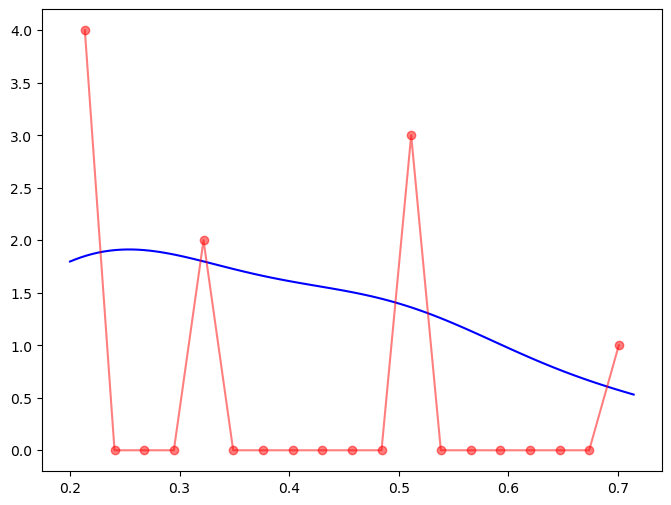

In [6]:
#--------------------Visualisation across subset of test dataset-------------------

#sample 100 image per digit
labels = full_dataset.targets.numpy()
sampled_indices = []
for digit in range(10):
    digit_indices = np.where(labels == digit)[0] 
    sampled = np.random.choice(digit_indices, 1, replace=False)
    sampled_indices.extend(sampled)

print(len(sampled_indices))
kscores = []
losses = []
ncc_intervals = [round(i * 0.1, 1) for i in range(-10, 10)]  # [-1.0, -0.9, ..., 0.9]
ncc_loss_dict = {
    f"{lower:.1f}-{lower + 0.1:.1f}": [] 
    for lower in ncc_intervals
}
epsilon = 1e-8

for i in sampled_indices:
    _, label = full_dataset[i]
    print(f"\nGenerating K-Score for index {i} of label {label}")
    vectorb = imgcalc.get_vectorb_model(i, model, NCC_dataset)
    vectorc = imgcalc.get_vectorc_model(i, model, input_dataset)
    kscore, _, _ = imgcalc.get_kscore_and_sets(vectorb, vectorc, k)
    kscores.append(kscore)
    print(f"K-Score for index {i} is {kscore}")
    
    loss = []
    
    for j in range(len(NCC_dataset)):
        NCC_scaled_value = imgcalc.get_NCC_score(NCC_dataset[i], NCC_dataset[j])
        embedded_vector_image1 = model(input_dataset[i])
        embedded_vector_image2 = model(input_dataset[j])
        dot_product_value = imgcalc.get_dp_score(embedded_vector_image1, embedded_vector_image2)
        loss_value = imgcalc.get_loss_value(dot_product_value, NCC_scaled_value) 
        loss.append(loss_value)
        
        # Find matching NCC interval
        lower_bound = math.floor(NCC_scaled_value * 10) / 10
        
        # Handle edge case for values == 1.0
        if lower_bound > 0.9 or NCC_scaled_value == 1.0:
            lower_bound = 0.9
        interval_key = f"{lower_bound:.1f}-{lower_bound + 0.1:.1f}"
        
        # Store loss in the appropriate interval
        ncc_loss_dict[interval_key].append(loss_value)
    
    average_loss = sum(loss) / len(loss)  
    print(f"Average loss for index {i} is {average_loss}")
    losses.append(average_loss)

average_loss_per_interval = {
    interval: sum(values)/len(values) if values else 0
    for interval, values in ncc_loss_dict.items()
}

print("\nNCC Interval\t\tAverage Loss")
for interval in sorted(ncc_loss_dict.keys()):
    avg_loss = average_loss_per_interval[interval]
    count = len(ncc_loss_dict[interval])
    print(f"{interval}\t\t{avg_loss:.4f} ({count} samples)")
    
imgplt.plot_score_distribution(kscores, "K-Score")
imgplt.plot_score_distribution(losses, "Loss")

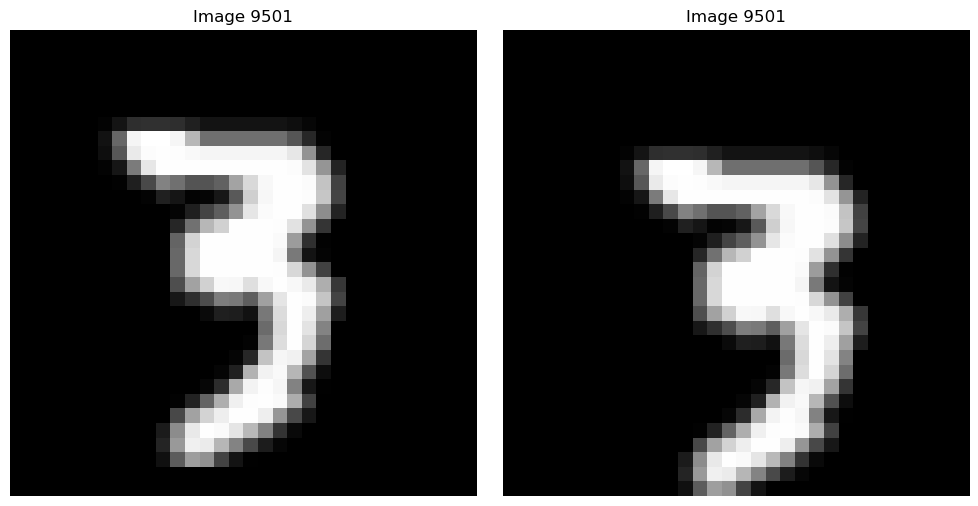

Are they unique of each other:  False

Loss calculation

Scaled NCC:  1.0
Dot product value of model:  0.9994184970855713
Loss:  0.0005815029144287109
tensor([[-0.0008,  0.0251,  0.0455,  0.1058,  0.0046,  0.0093,  0.1561,  0.1098,
         -0.0285, -0.0746,  0.1027,  0.1104, -0.1080,  0.0565, -0.0579, -0.0405,
          0.0048, -0.0647, -0.0557,  0.1038,  0.1220, -0.2038,  0.1070, -0.0640,
         -0.0564, -0.0947, -0.1024, -0.0739, -0.0625,  0.0946,  0.0330,  0.1224,
         -0.0018,  0.0317,  0.1019,  0.0928, -0.0630,  0.0808, -0.1027,  0.0674,
         -0.0836, -0.1399, -0.1218, -0.0585,  0.0258, -0.0077,  0.0972, -0.0564,
         -0.0366,  0.1188, -0.0422,  0.0232,  0.0618, -0.1271, -0.0740, -0.0426,
          0.1650,  0.0045, -0.1265,  0.1496,  0.1122, -0.1044,  0.1948, -0.0295,
          0.0124,  0.0225, -0.0752, -0.0005, -0.0836, -0.0752, -0.0557, -0.1198,
          0.0562,  0.0736, -0.1637, -0.0199, -0.0678, -0.0150,  0.0334,  0.1218,
         -0.0150, -0.0620,  0.1238,  0.

In [6]:
# --------------------- Test LPS layer && Test translationally similar images --------------------
class CNN(nn.Module):
    def __init__(self, dimensions=128):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)

        self.pool1= nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        
        self.lpd = set_pool(partial(
            PolyphaseInvariantDown2D,
            component_selection=LPS,
            get_logits=get_logits_model('LPSLogitLayers'),
            pass_extras=False
            ),p_ch=128,h_ch=128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4   = nn.BatchNorm2d(256)
        
        self.relu = nn.LeakyReLU(0.1)
        
        self.adapt_pool = nn.AdaptiveAvgPool2d((1, 1)) 

        self.fc1 = nn.Linear(256, dimensions)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool1(x) 
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.lpd(x)    # 16x16 -> 8x8
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x) 
        
        x = self.adapt_pool(x) 
        
        x = torch.flatten(x, start_dim=1)  
        x = self.fc1(x)                    
        
        x = F.normalize(x, p=2, dim=1)
        return x
    
model = CNN().cuda()
#model.load_state_dict(torch.load('model/best_model_batch_greyscale_mnistComplexCNN.pt', weights_only=True))
#model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ----------------------------------Preparing the Dataset----------------------------------
augmentation_transform = transforms.Compose([
    transforms.Resize((32, 32)), 
    transforms.RandomAffine(
        degrees=0,  # No rotation
        translate=(0.1, 0.1),  # Random horizontal/vertical shifts (10% of image size)
        fill=0  # Pad with black (MNIST background)
    ),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

augmented_testset = torchvision.datasets.MNIST(root='./data', train=False, transform=augmentation_transform)


input_dataset_augmented = []
for i in range(len(augmented_testset)):
    image,label = augmented_testset[i]
    img = image.unsqueeze(0).cuda().double()  #1x1xHxW
    input_dataset_augmented.append(img)

stacked_tensor = torch.stack(input_dataset_augmented)
input_dataset_augmented = stacked_tensor.cpu().numpy()      
input_dataset_augmented = [torch.tensor(data).cuda().float() for data in input_dataset_augmented]

NCC_dataset_augmented = []
for i in range(len(augmented_testset)):
    image,label = augmented_testset[i]
    image_array = image.numpy()
    NCC_dataset_augmented.append(image_array.squeeze()) 
    
input1 = NCC_dataset[index1]
input2 = NCC_dataset_augmented[index1]

np.savez('data.npz', input1=input1, input2=input2)

imgplt.plot_original_images(input1, input2, index1, index1)

print("Are they unique of each other: ", imgcalc.check_translationally_unique(input1,input2))

NCC_scaled_value = imgcalc.get_NCC_score(input1, input2)
print("\nLoss calculation")
print("\nScaled NCC: ",NCC_scaled_value)

embedded_vector_image1 = model(input_dataset[index1])
embedded_vector_image2 = model(input_dataset_augmented[index1])

dot_product_value = imgcalc.get_dp_score(embedded_vector_image1, embedded_vector_image2)

print("Dot product value of model: ", dot_product_value.item())

loss_value = imgcalc.get_loss_value(dot_product_value, NCC_scaled_value) 
print("Loss: ", loss_value)

print(embedded_vector_image1)
print(embedded_vector_image2)
print(embedded_vector_image1-embedded_vector_image2)